In [24]:
# SOLA Failure Demonstration
# ==========================
# This notebook demonstrates how SOLA can fail when the true model
# does not have a small norm. We will show that SOLA's property estimates
# can be completely wrong even when the method appears to work correctly.

from pygeoinf.interval import IntervalDomain, Lebesgue, SOLAOperator, Function
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf import EuclideanSpace, ColumnLinearOperator, CholeskySolver, GaussianMeasure, LinearOperator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set-up folder for saving figures
figures_folder = 'sola_failure'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Part 1: Problem Setup

We set up a standard SOLA problem with:
- A model space $M$ (Lebesgue space on $[0,1]$)
- A data space $D$ (Euclidean space)
- A property space $P$ (Euclidean space)
- A forward operator $G: M \to D$ with sensitivity kernels
- A target operator $T: M \to P$ with target kernels

In [25]:
# Create function domain and spaces
function_domain = IntervalDomain(0, 1)

M = Lebesgue(0, function_domain, basis=None)  # Model space (baseless)
N_d = 100  # Number of data points
D = EuclideanSpace(N_d)  # Data space
N_p = 20  # Number of property points
P = EuclideanSpace(N_p)  # Property space

print(f"Model space: L²([{function_domain.a}, {function_domain.b}])")
print(f"Data space: ℝ^{N_d}")
print(f"Property space: ℝ^{N_p}")

Model space: L²([0.0, 1.0])
Data space: ℝ^100
Property space: ℝ^20


In [26]:
# Create forward operator G and target operator T
width = 0.2  # Width of bump target functions
centers = np.linspace(function_domain.a + width/2, function_domain.b - width/2, N_p)

# Forward operator: random normal modes (sensitivity kernels)
normal_modes_provider = NormalModesProvider(
    M,
    n_modes_range=(1, 50),
    coeff_range=(-5, 5),
    gaussian_width_percent_range=(1, 5),
    freq_range=(0.1, 20),
    random_state=2,  # For reproducibility
)
G = SOLAOperator(M, D, normal_modes_provider)

# Target operator: bump functions (target kernels)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider)

print(f"Forward operator G: M → D")
print(f"Target operator T: M → P")

Forward operator G: M → D
Target operator T: M → P


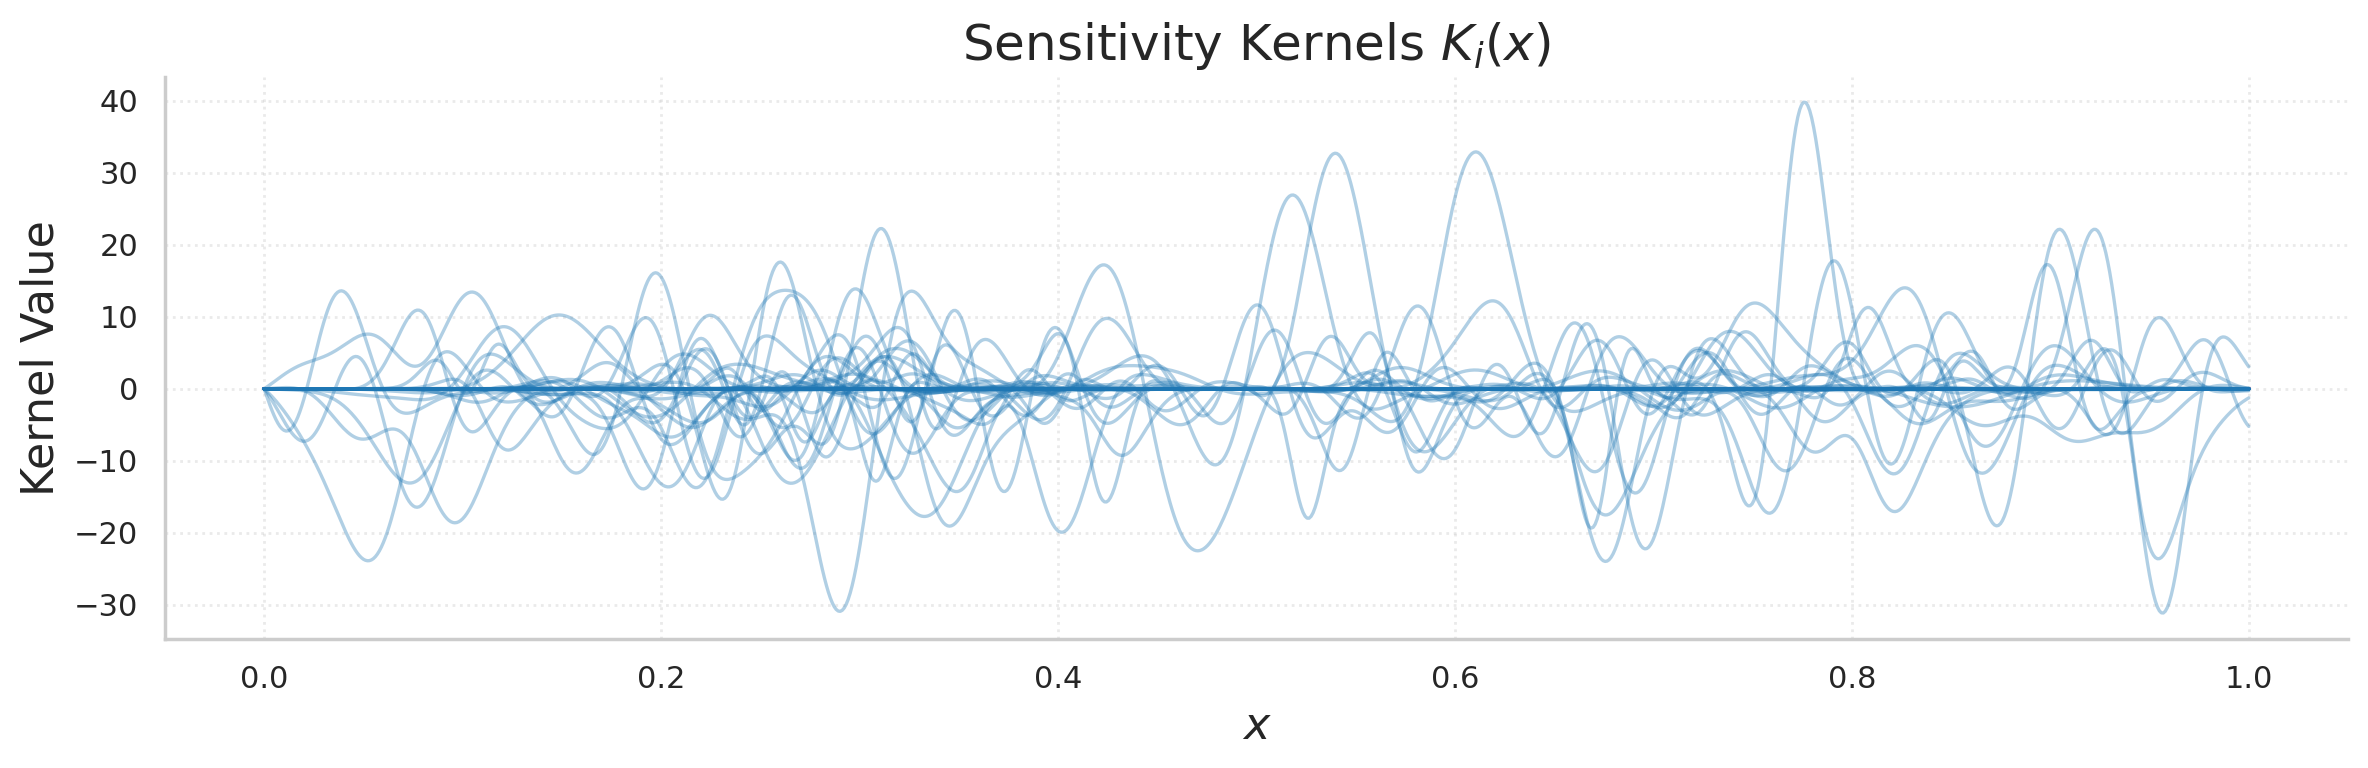

In [27]:
# Visualization: Sensitivity Kernels
x = np.linspace(function_domain.a, function_domain.b, 1000)

fig_title = "Sensitivity Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
for i in range(N_d):
    plt.plot(x, G.get_kernel(i).evaluate(x), color='tab:blue', alpha=0.35, linewidth=1.2)

plt.title(r"Sensitivity Kernels $K_i(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

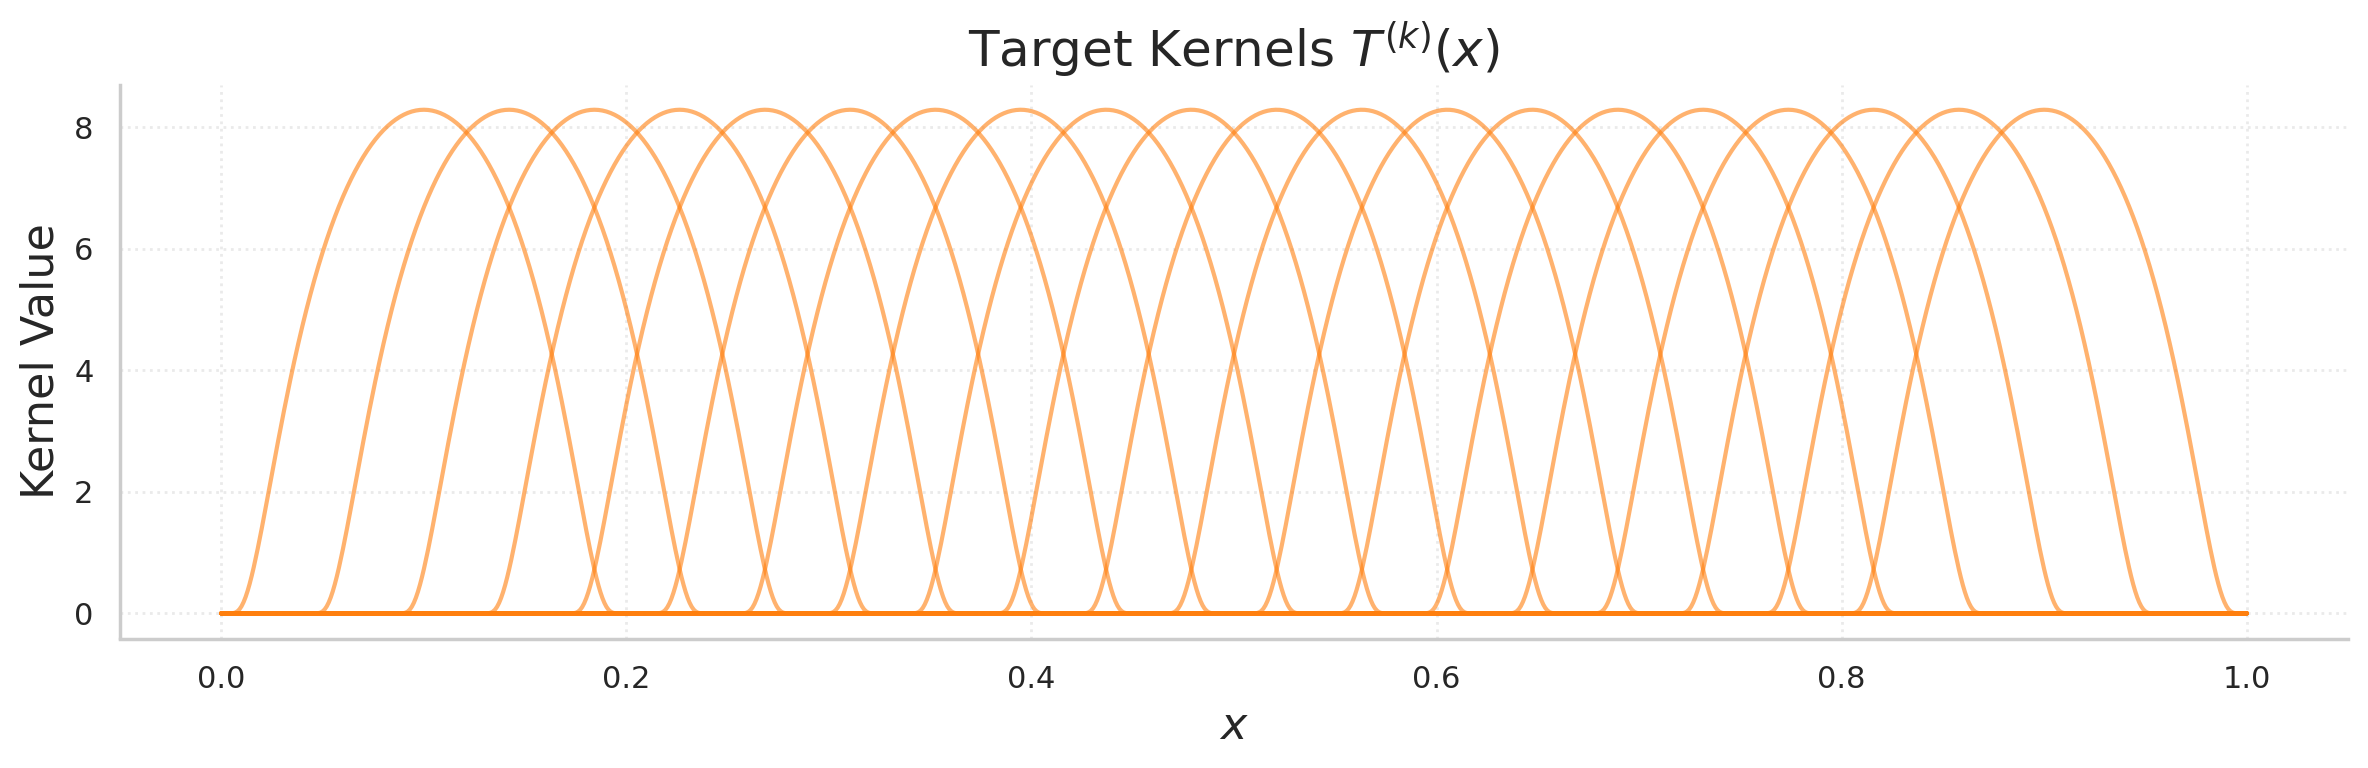

In [28]:
# Visualization: Target Kernels
fig_title = "Target Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
for i in range(N_p):
    plt.plot(x, T.get_kernel(i).evaluate(x), color='tab:orange', alpha=0.6, linewidth=1.5)

plt.title(r"Target Kernels $T^{(k)}(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Part 2: Behind the Scenes (Hidden from the "User")

This section simulates what happens when someone prepares a SOLA problem for another person.
The "experimenter" knows the true model, but the "analyst" only receives:
- The operators $G$ and $T$
- The noisy data $\tilde{d}$
- The data covariance $C_D$

**The twist**: We will construct a *pathological* true model that:
1. Produces the exact same observed data as a "normal" true model
2. Has vastly different true properties

This demonstrates that SOLA can fail when the true model doesn't have small norm.

In [29]:
# Step 1: Create a "normal" true model with small norm
m_normal = Function(M, evaluate_callable=lambda x:
    np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)

# Compute the true data from the normal model
d_bar = G(m_normal)

# Add noise to create the observed data
noise_level = 0.1 * np.max(np.abs(d_bar))
np.random.seed(42)
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)

# Compute the "normal" true properties
p_normal = T(m_normal)

print(f"Normal true model norm: {M.norm(m_normal):.4f}")
print(f"Normal true properties: min={np.min(p_normal):.4f}, max={np.max(p_normal):.4f}")

Normal true model norm: 0.8237
Normal true properties: min=-0.3813, max=1.3318


In [30]:
# Step 2: Construct a PATHOLOGICAL true model
# This model fits the SAME DATA but has OPPOSITE properties!

# Create the joint operator [G; T]
G_T = ColumnLinearOperator([G, T])

# Target properties: the NEGATIVE of the normal true properties
p_pathological_target = -p_normal

# Form the joint "constraint" vector: fit the true data AND the pathological properties
d_constraint = [d_bar, p_pathological_target]

# Find the minimum norm model that satisfies both constraints
solver = CholeskySolver(galerkin=False, parallel=True, n_jobs=12)
W_hat_inv = solver(G_T @ G_T.adjoint)
m_pathological = (G_T.adjoint @ W_hat_inv)(d_constraint)

# Verify the pathological model
print("Pathological model verification:")
print(f"  Data fit error: {np.linalg.norm(G(m_pathological) - d_bar):.2e}")
print(f"  Property fit error: {np.linalg.norm(T(m_pathological) - p_pathological_target):.2e}")
print(f"  Pathological model norm: {M.norm(m_pathological):.4f}")
print(f"\nThe pathological model has norm {M.norm(m_pathological)/M.norm(m_normal):.1f}x larger than the normal model!")

Pathological model verification:
  Data fit error: 4.48e-07
  Data fit error: 4.48e-07
  Property fit error: 9.91e-08
  Pathological model norm: 2069.2248
  Property fit error: 9.91e-08
  Pathological model norm: 2069.2248

The pathological model has norm 2512.0x larger than the normal model!

The pathological model has norm 2512.0x larger than the normal model!


In [31]:
# Step 3: Store the TRUE properties (from the pathological model)
# This is what the "analyst" doesn't know!
p_true = T(m_pathological)  # These are the actual true properties
m_true = m_pathological     # This is the actual true model

print("The 'analyst' will receive:")
print(f"  - Operators G, T")
print(f"  - Noisy data d̃ (based on d_bar from pathological model)")
print(f"  - Data covariance C_D")
print("\nThey do NOT know:")
print(f"  - The true model m_true")
print(f"  - The true properties p_true = T(m_true)")

The 'analyst' will receive:
  - Operators G, T
  - Noisy data d̃ (based on d_bar from pathological model)
  - Data covariance C_D

They do NOT know:
  - The true model m_true
  - The true properties p_true = T(m_true)


# Part 3: The Analyst's Perspective (Standard SOLA Application)

From here on, we simulate what the "analyst" sees. They receive:
- Forward operator $G$
- Target operator $T$
- Noisy observations $\tilde{d}$
- Data covariance $C_D$

They do NOT know the true model or its properties. They will apply SOLA in the standard way.

In [32]:
# Define the data noise covariance (known to the analyst)
noise_variance = noise_level**2
C_D_matrix = noise_variance * np.eye(N_d)

# Create data noise measure for SOLA
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure with observed data mean
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

print("Data uncertainty model:")
print(f"  Noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"  Relative noise level: {100 * np.sqrt(noise_variance) / np.max(np.abs(d_tilde)):.1f}%")

Data uncertainty model:
  Noise standard deviation: 0.1088
  Relative noise level: 9.8%


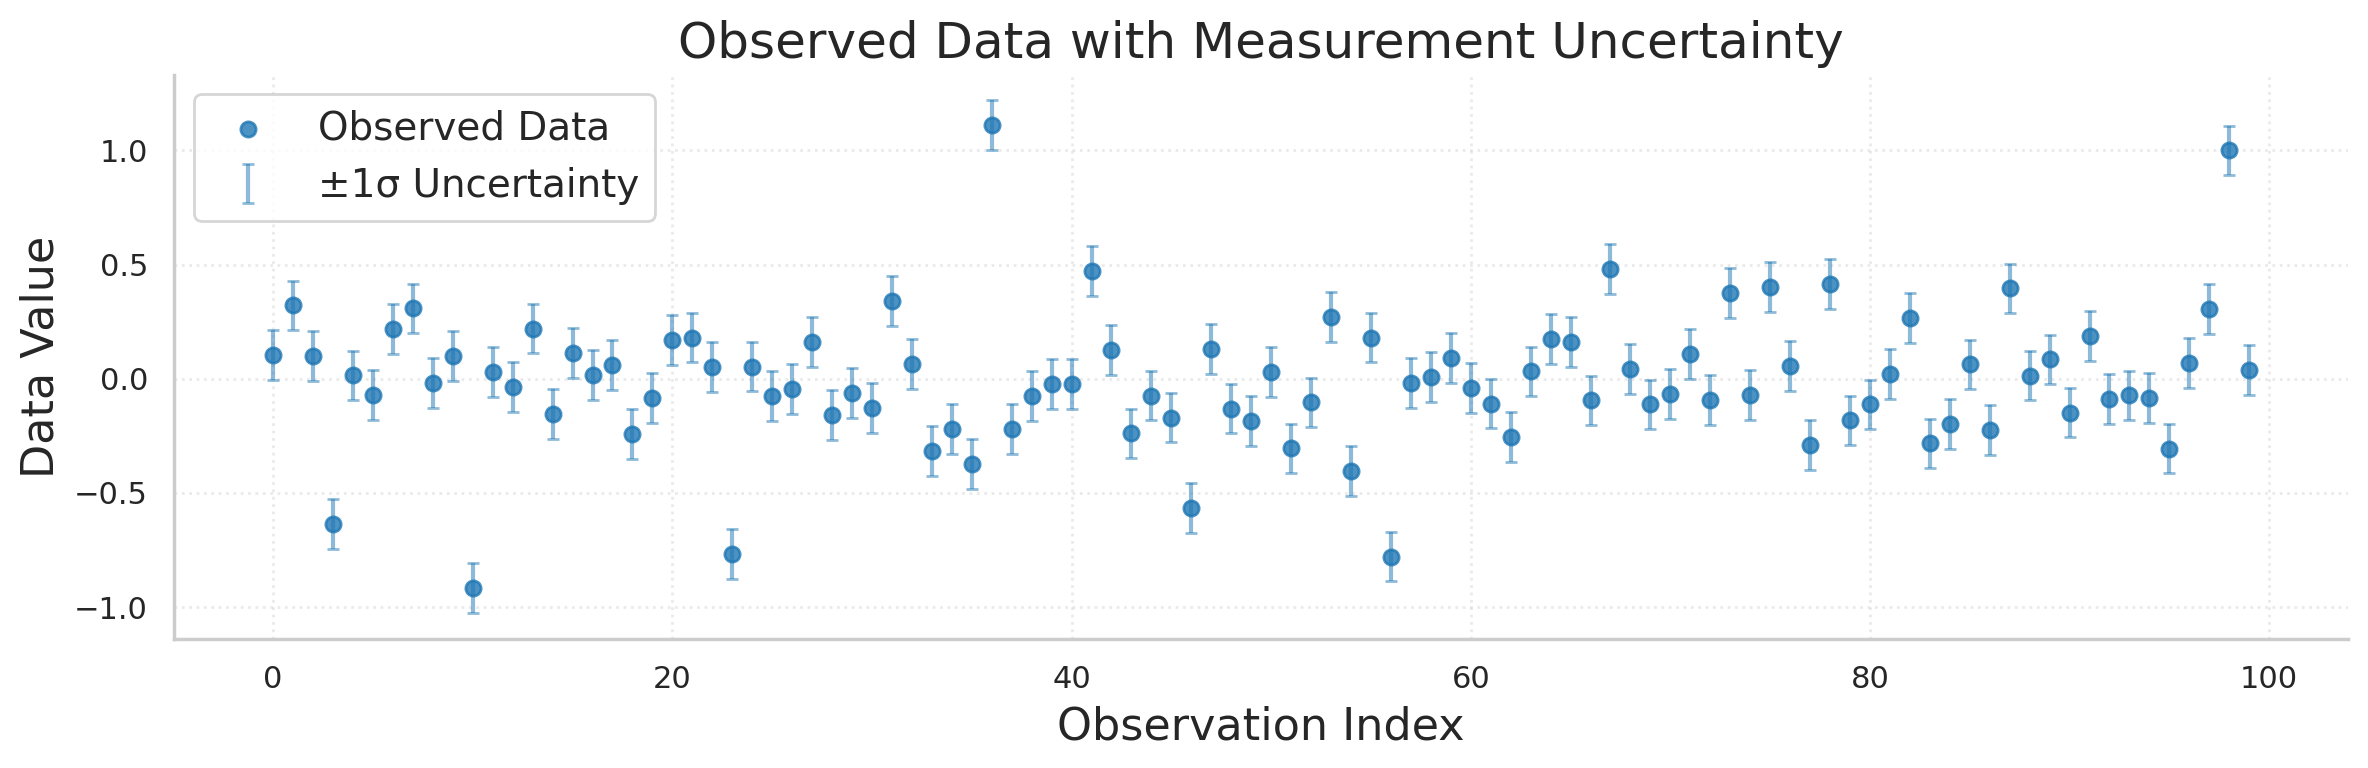

In [33]:
# Visualize the observed data with uncertainty
fig_title = "Observed Data"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_tilde))
std_values = np.sqrt(noise_variance)

plt.scatter(data_indices, d_tilde, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, d_tilde, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1, label='±1σ Uncertainty')

plt.title("Observed Data with Measurement Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

In [34]:
# Compute SOLA operator components
print("Computing SOLA operator...")

# Step 1: Compute normal operator Λ = GG*
print("  - Computing Gram matrix Λ = GG*...")
Lambda = G @ G.adjoint

# Step 2: Solve (Λ + C_D)^{-1}
print("  - Computing regularized inverse W⁻¹ = (Λ + C_D)⁻¹...")
cholesky_solver = CholeskySolver(galerkin=False, parallel=True, n_jobs=12)
W_inv = cholesky_solver(Lambda + gaussian_D.covariance)

# Step 3: Compute generalized inverse G† = G* W^{-1}
print("  - Computing generalized inverse G† = G*W⁻¹...")
G_inv = G.adjoint @ W_inv

print("✓ SOLA operator components computed!")

Computing SOLA operator...
  - Computing Gram matrix Λ = GG*...
  - Computing regularized inverse W⁻¹ = (Λ + C_D)⁻¹...
  - Computing generalized inverse G† = G*W⁻¹...
✓ SOLA operator components computed!
  - Computing generalized inverse G† = G*W⁻¹...
✓ SOLA operator components computed!


In [35]:
# Compute SOLA property operator X = T G†
print("Computing SOLA property operator X = TG†...")
X = T @ G_inv

# Apply unimodularity constraint
print("Applying unimodularity constraint...")

# Create constant unit function
M_one = Function(M, evaluate_callable=lambda x: np.ones_like(x))
v = G(M_one)
w = np.ones(N_p)
u = W_inv(v)
beta = D.inner_product(v, u)
correction = LinearOperator.from_matrix(D, P, np.outer((X(v) - w) / beta, u))
X_unimodular = X - correction

print(f"Unimodularity check: X_uni(G(1)) = {X_unimodular(v)}")
print("✓ Unimodular SOLA operator ready!")

Computing SOLA property operator X = TG†...
Applying unimodularity constraint...
Unimodularity check: X_uni(G(1)) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Unimodular SOLA operator ready!
Unimodularity check: X_uni(G(1)) = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Unimodular SOLA operator ready!


In [36]:
# Apply SOLA to get property estimates with uncertainty
property_measure = gaussian_D.affine_mapping(operator=X_unimodular)

# Extract mean and standard deviation
p_sola = property_measure.expectation
P_cov_mat = property_measure.covariance.matrix(dense=True, parallel=True, n_jobs=8)
p_std = np.sqrt(np.diag(P_cov_mat))

print("SOLA property estimation complete!")
print(f"  Property estimates: min={np.min(p_sola):.4f}, max={np.max(p_sola):.4f}")
print(f"  Average uncertainty (1σ): {np.mean(p_std):.4f}")

SOLA property estimation complete!
  Property estimates: min=-0.3846, max=1.3971
  Average uncertainty (1σ): 0.1564


# Part 4: SOLA Results (What the Analyst Sees)

The analyst now has property estimates with uncertainty quantification.
They can visualize their results, but they don't know the true properties to compare against.

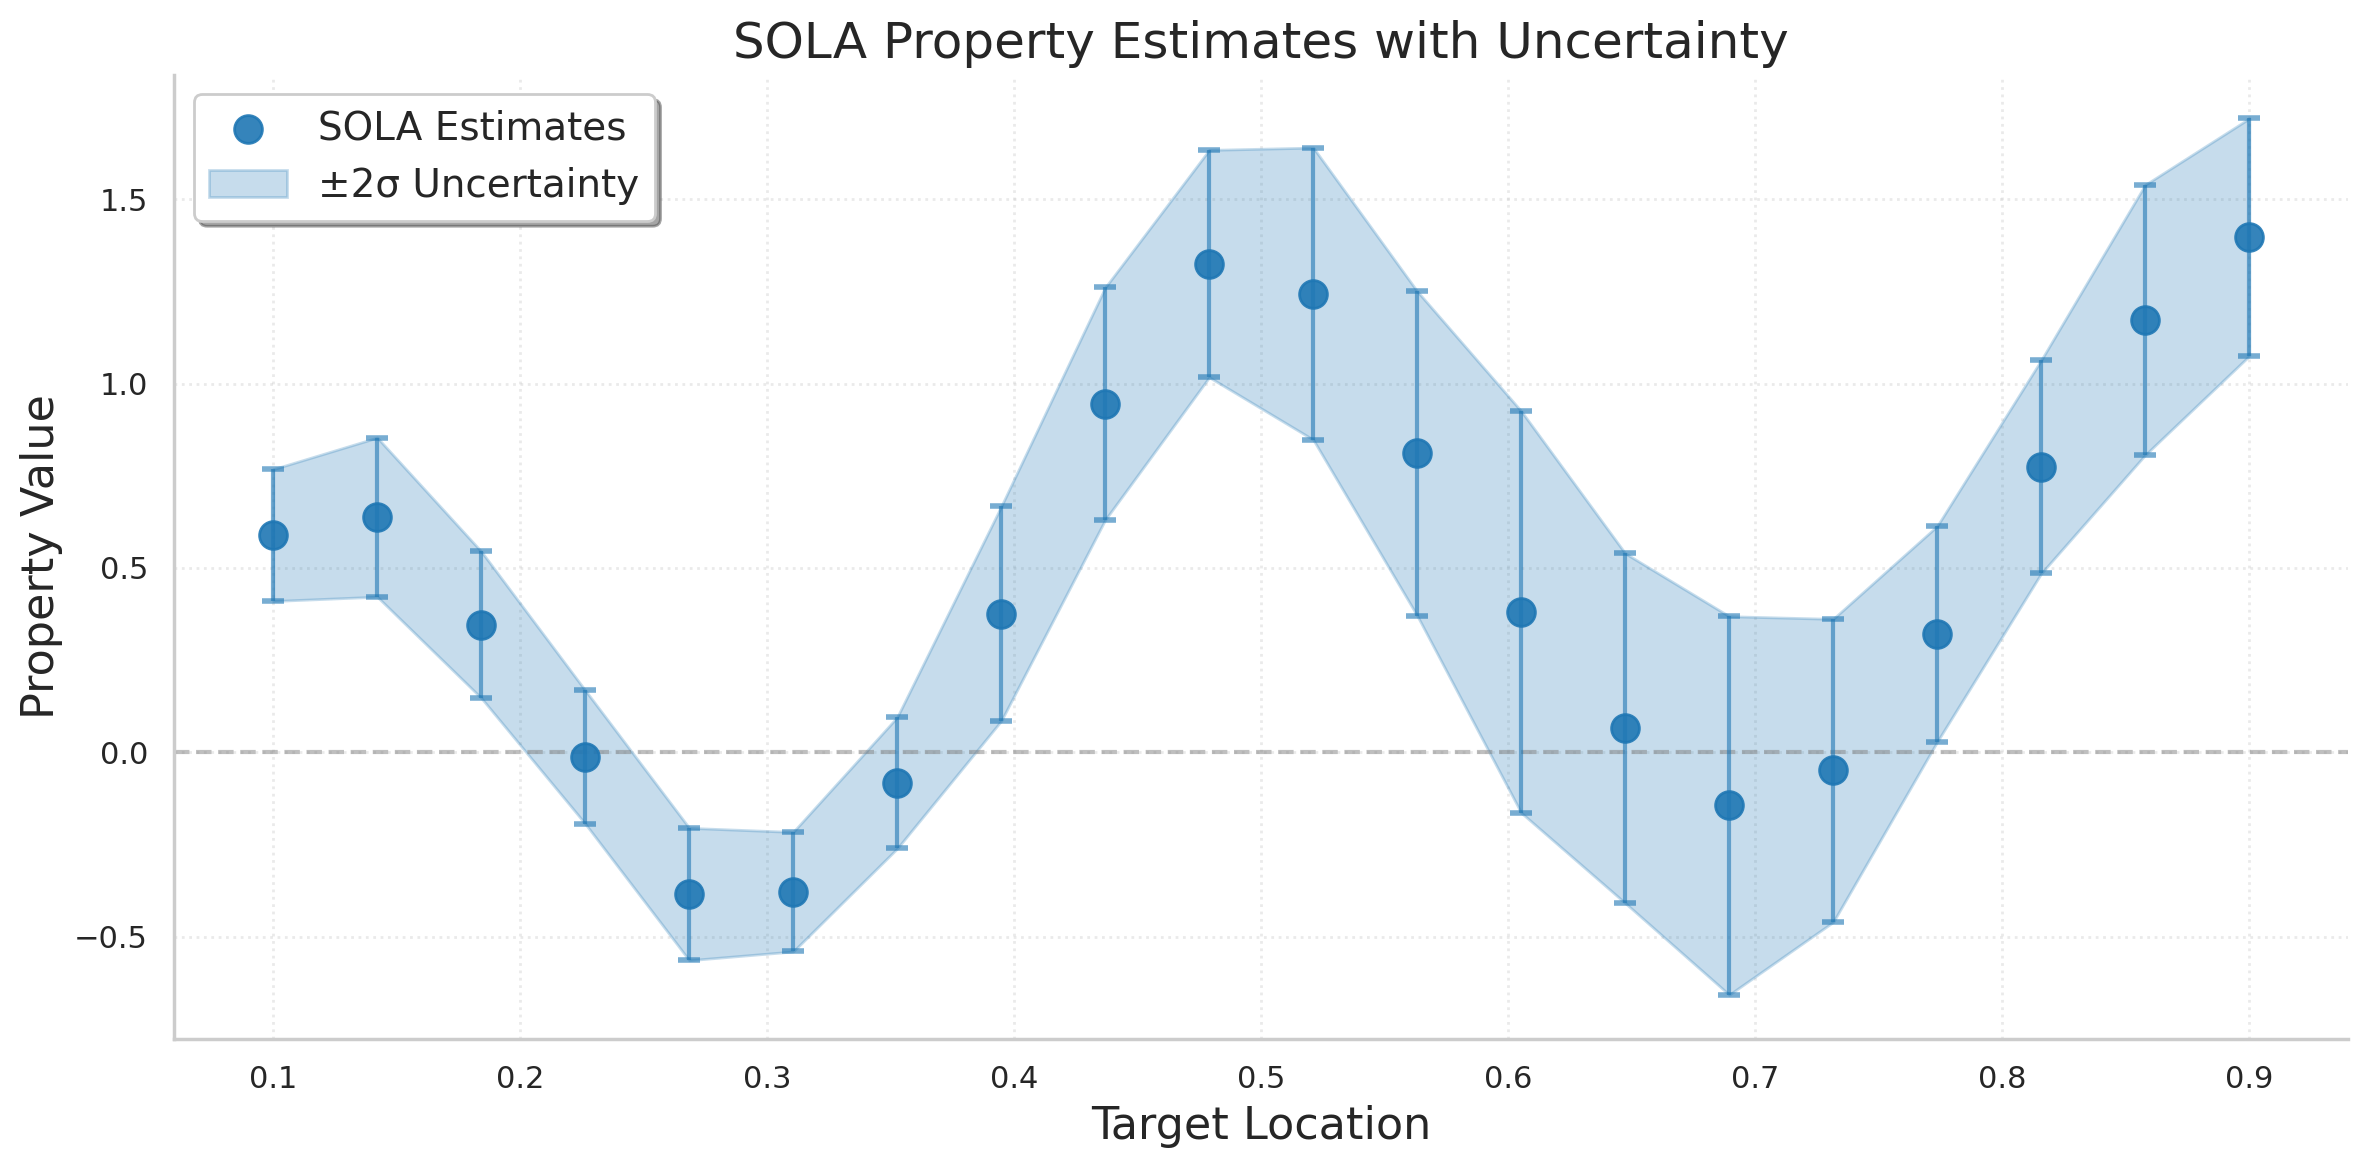


The analyst is satisfied - they have property estimates with uncertainty!
But are these estimates actually correct? They have no way to know...


In [37]:
# Visualize SOLA property estimates (analyst's view - no true values shown)
fig_title = "SOLA Property Estimates"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

plt.scatter(centers, p_sola, label='SOLA Estimates',
           color='tab:blue', marker='o', s=100, alpha=0.9, zorder=5)
plt.fill_between(centers, p_sola - 2*p_std, p_sola + 2*p_std,
                alpha=0.25, color='tab:blue', label='±2σ Uncertainty', zorder=1)
plt.errorbar(centers, p_sola, yerr=2*p_std, fmt='none',
            ecolor='tab:blue', alpha=0.6, capsize=4, capthick=2, zorder=3)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('SOLA Property Estimates with Uncertainty', fontsize=18)
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

print("\nThe analyst is satisfied - they have property estimates with uncertainty!")
print("But are these estimates actually correct? They have no way to know...")

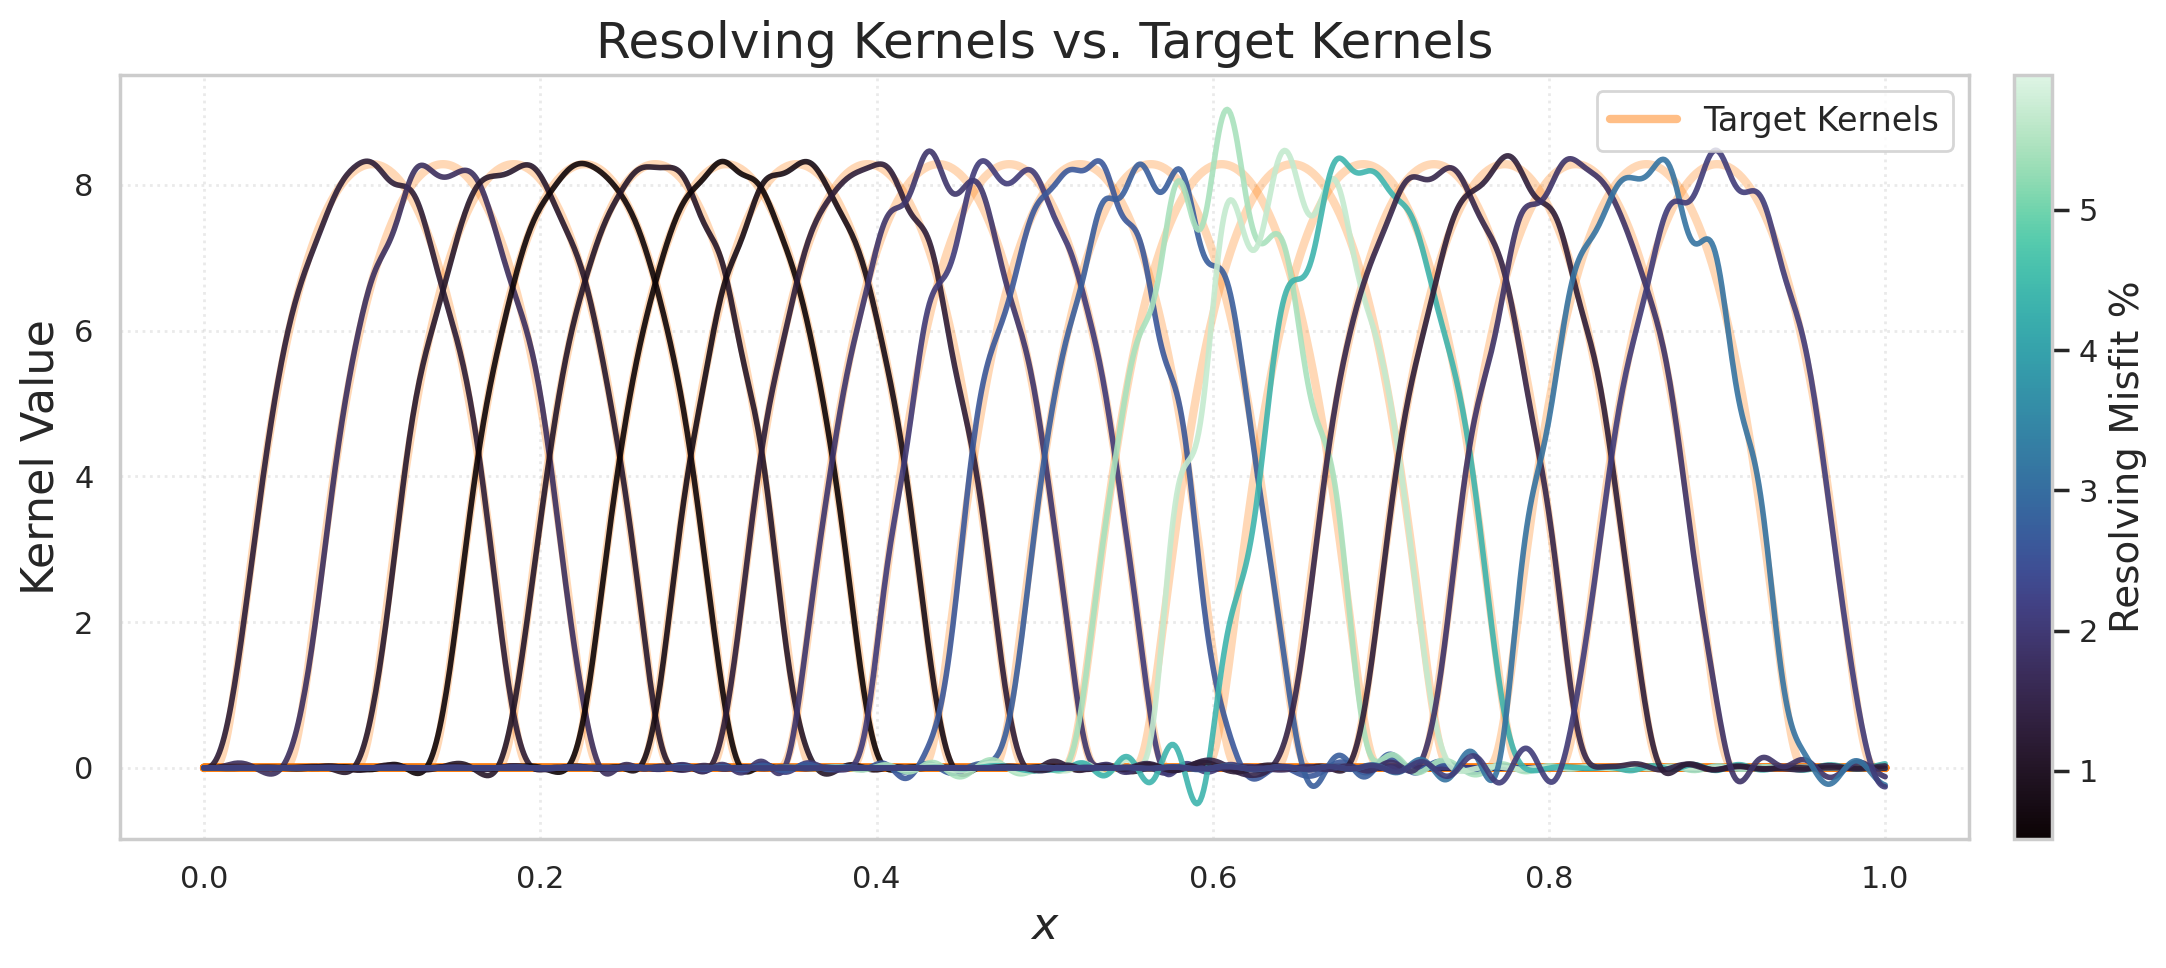


Resolving kernel quality:
  Average misfit: 2.1%
  Max misfit: 5.7%

The resolving kernels match the target kernels quite well!
This suggests SOLA should work... but will it?


In [ ]:
# Visualize resolving kernels vs target kernels
# The analyst can check how well the resolving kernels match the targets
from matplotlib import cm

A_adjoint = (X @ G).adjoint

cp = np.zeros(N_p)
resolving_misfits = np.zeros(N_p)

# Compute all resolving residuals first for normalization
for i in range(N_p):
    cp[i] = 1
    A_i = A_adjoint(cp)
    target_kernel = T.get_kernel(i)
    resolving_misfits[i] = M.norm(A_i - target_kernel) / M.norm(target_kernel)
    cp[i] = 0

# Convert misfits to percent for visualization
resolving_misfits_percent = 100 * resolving_misfits

# Normalize colormap to the actual range of misfits (with a small margin)
vmin = resolving_misfits_percent.min() * 0.95
vmax = resolving_misfits_percent.max() * 1.05
norm = plt.Normalize(vmin, vmax)
cmap = plt.colormaps.get_cmap("mako")

fig, ax = plt.subplots(figsize=(12, 5), dpi=200)

# First, plot target kernels in the background (light orange)
for i in range(N_p):
    target_kernel = T.get_kernel(i)
    ax.plot(x, target_kernel.evaluate(x), color='tab:orange', alpha=0.3,
            linewidth=3, linestyle='-', zorder=1)

# Then, plot resolving kernels on top (colored by misfit)
for i in range(N_p):
    cp[i] = 1
    A_i = A_adjoint(cp)
    color = cmap(norm(resolving_misfits_percent[i]))
    ax.plot(x, A_i.evaluate(x), alpha=0.9, linewidth=2, color=color, zorder=2)
    cp[i] = 0

# Add a dummy line for the legend
ax.plot([], [], color='tab:orange', alpha=0.5, linewidth=3, label='Target Kernels')

ax.set_title("Resolving Kernels vs. Target Kernels", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel("Kernel Value", fontsize=16)
ax.legend(fontsize=12, loc='upper right')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Resolving Misfit %", fontsize=14)

ax.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()
fig.savefig(os.path.join(figures_folder, "resolving_kernels.png"), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(figures_folder, "resolving_kernels.pdf"), bbox_inches='tight')
plt.show()

print(f"\nResolving kernel quality:")
print(f"  Average misfit: {np.mean(resolving_misfits_percent):.1f}%")
print(f"  Max misfit: {np.max(resolving_misfits_percent):.1f}%")
print(f"\nThe resolving kernels match the target kernels quite well!")
print("This suggests SOLA should work... but will it?")

# Part 5: The Reveal - SOLA Has Failed!

Now we reveal what the analyst doesn't know: the TRUE properties of the actual true model.
We will see that SOLA's estimates are completely wrong - not just slightly off, but
in complete contradiction with the truth!

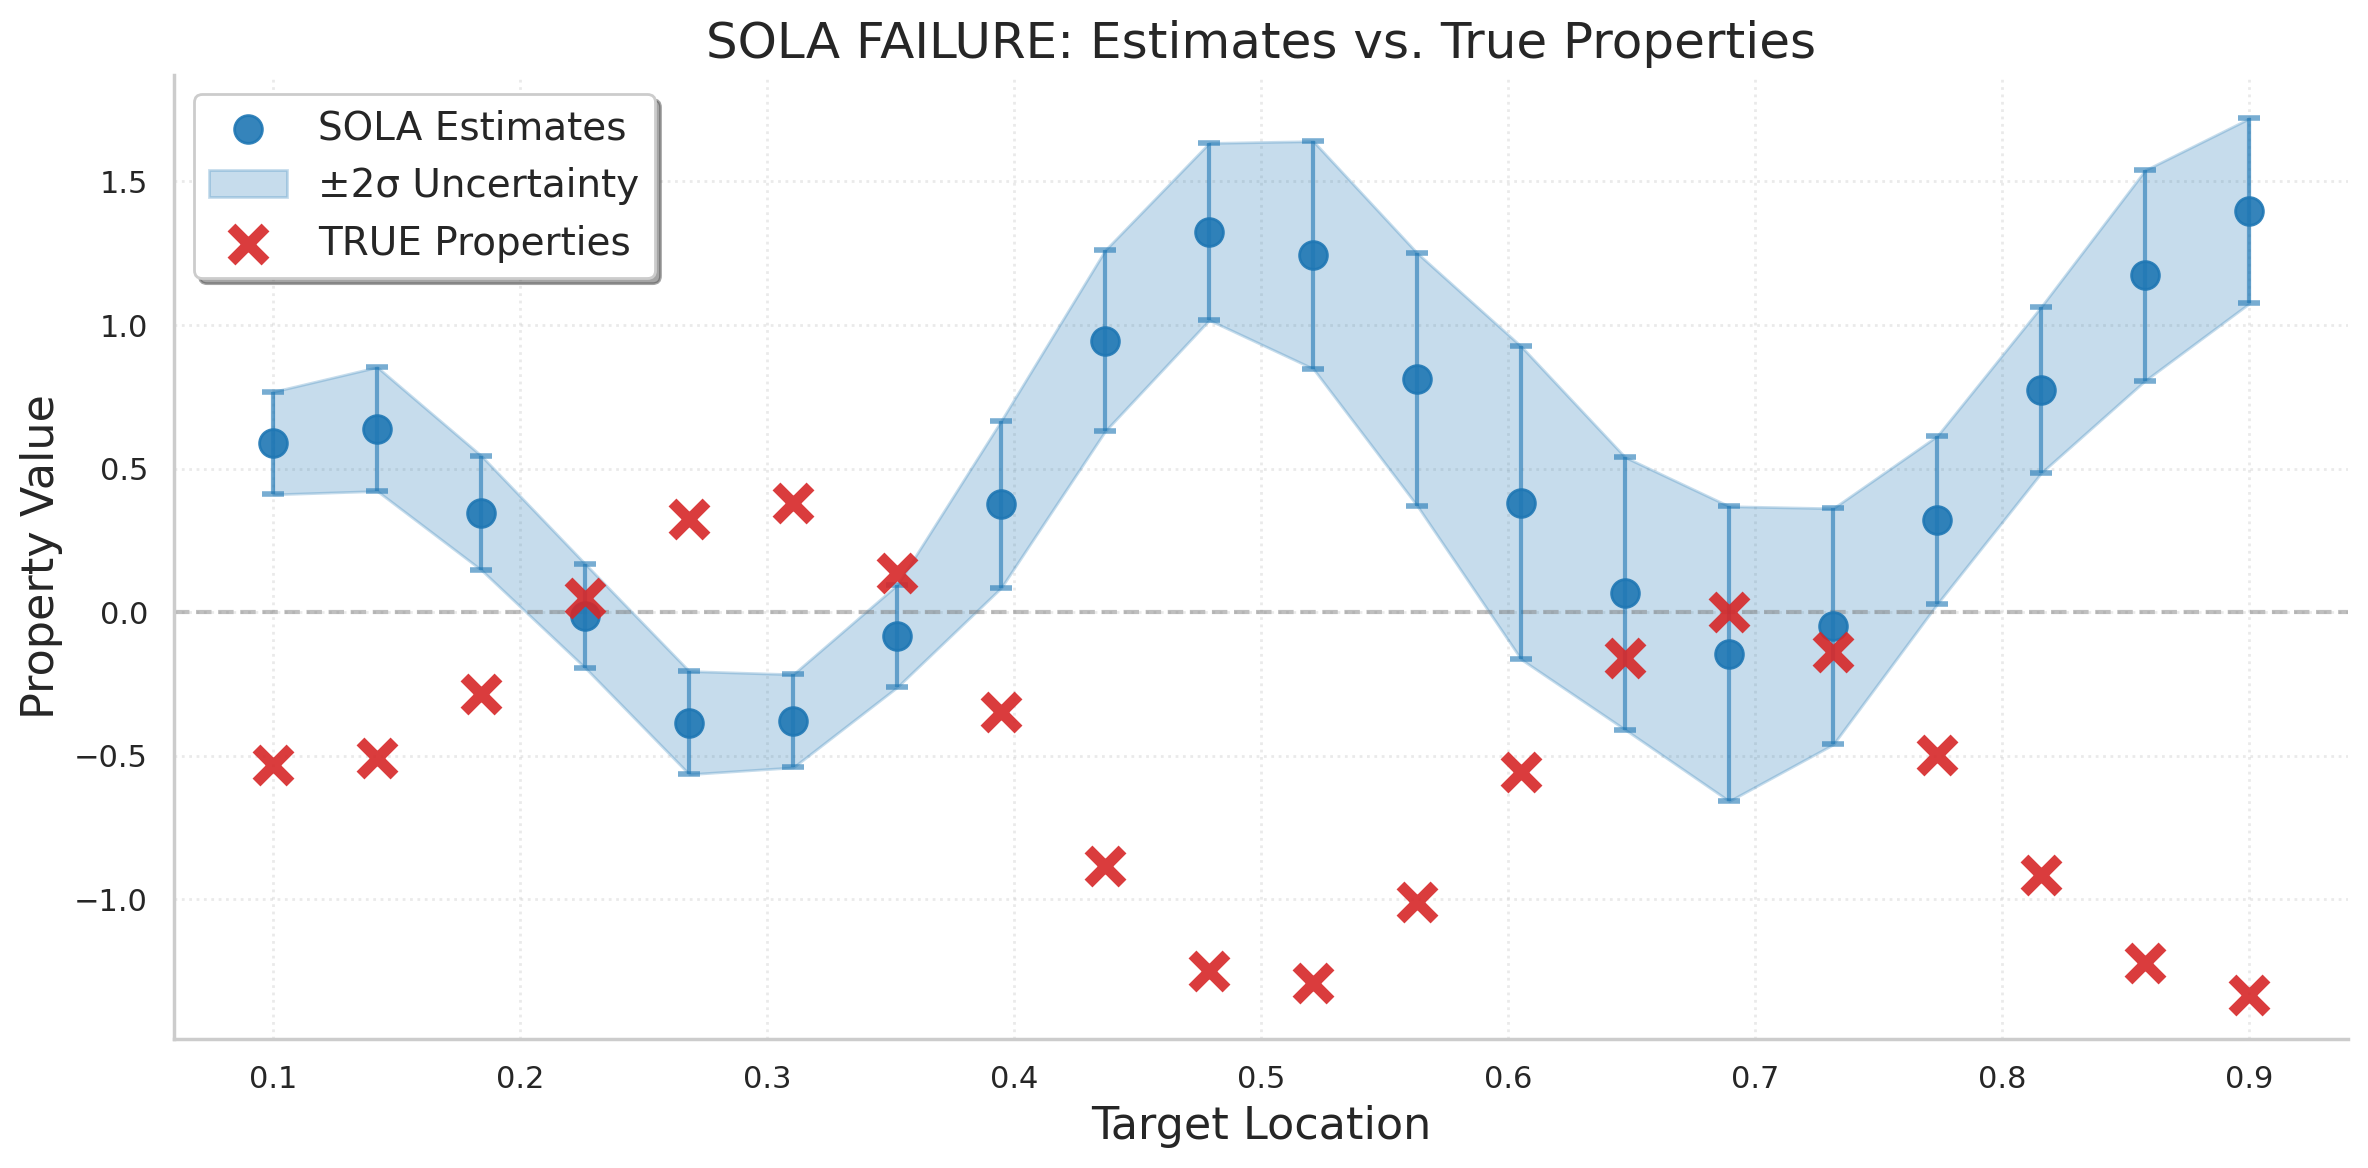


SOLA FAILURE ANALYSIS
Properties within ±2σ: 4/20 (20.0%)
  Expected for valid inference: ~95%

Mean absolute error: 1.1580
RMS error: 1.4492
Max error: 2.7290
Average uncertainty (2σ): 0.3129

Error/Uncertainty ratio: 7.4x

⚠️  SOLA has catastrophically failed!
The estimates are not just wrong, they are in the OPPOSITE direction!


In [39]:
# REVEAL: Compare SOLA estimates with the TRUE properties
fig_title = "SOLA Failure Revealed"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Plot SOLA estimates
plt.scatter(centers, p_sola, label='SOLA Estimates',
           color='tab:blue', marker='o', s=100, alpha=0.9, zorder=5)
plt.fill_between(centers, p_sola - 2*p_std, p_sola + 2*p_std,
                alpha=0.25, color='tab:blue', label='±2σ Uncertainty', zorder=1)
plt.errorbar(centers, p_sola, yerr=2*p_std, fmt='none',
            ecolor='tab:blue', alpha=0.6, capsize=4, capthick=2, zorder=3)

# Plot TRUE properties (THE REVEAL!)
plt.scatter(centers, p_true, label='TRUE Properties',
           color='tab:red', marker='x', s=150, alpha=0.9, linewidths=4, zorder=10)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('SOLA FAILURE: Estimates vs. True Properties', fontsize=18)
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment of the failure
property_errors = np.abs(p_sola - p_true)
within_2sigma = np.sum(property_errors <= 2*p_std)

print("\n" + "="*60)
print("SOLA FAILURE ANALYSIS")
print("="*60)
print(f"Properties within ±2σ: {within_2sigma}/{len(p_true)} ({100*within_2sigma/len(p_true):.1f}%)")
print(f"  Expected for valid inference: ~95%")
print(f"\nMean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty (2σ): {np.mean(2*p_std):.4f}")
print(f"\nError/Uncertainty ratio: {np.mean(property_errors)/np.mean(p_std):.1f}x")
print("="*60)
print("\n⚠️  SOLA has catastrophically failed!")
print("The estimates are not just wrong, they are in the OPPOSITE direction!")

# Part 6: Why Did SOLA Fail?

The key insight is that SOLA implicitly assumes the true model has **small norm**.
Specifically, SOLA uses the least-norm solution $\tilde{m} = G^\dagger \tilde{d}$, 
and the property estimate is essentially $T(\tilde{m})$.

When the true model has small norm, $\tilde{m}$ is close to the true model, so 
$T(\tilde{m}) \approx T(m_{true})$.

But when the true model has **large norm** (like our pathological model), 
the least-norm solution can be very different from the true model, 
even though both fit the data equally well!

In [40]:
# Compute the least-norm solution (what SOLA implicitly uses)
m_least_norm = G_inv(d_tilde)

print("Model comparison:")
print(f"  Least-norm solution ||m̃||: {M.norm(m_least_norm):.4f}")
print(f"  Pathological true model ||m_true||: {M.norm(m_true):.4f}")
print(f"  Ratio: {M.norm(m_true)/M.norm(m_least_norm):.1f}x")
print(f"\nThe true model has {M.norm(m_true)/M.norm(m_least_norm):.1f}x larger norm than the least-norm solution!")
print("This violates SOLA's implicit assumption.")

Model comparison:
  Least-norm solution ||m̃||: 2.1453
  Pathological true model ||m_true||: 2069.2248
  Ratio: 964.5x

The true model has 964.5x larger norm than the least-norm solution!
This violates SOLA's implicit assumption.


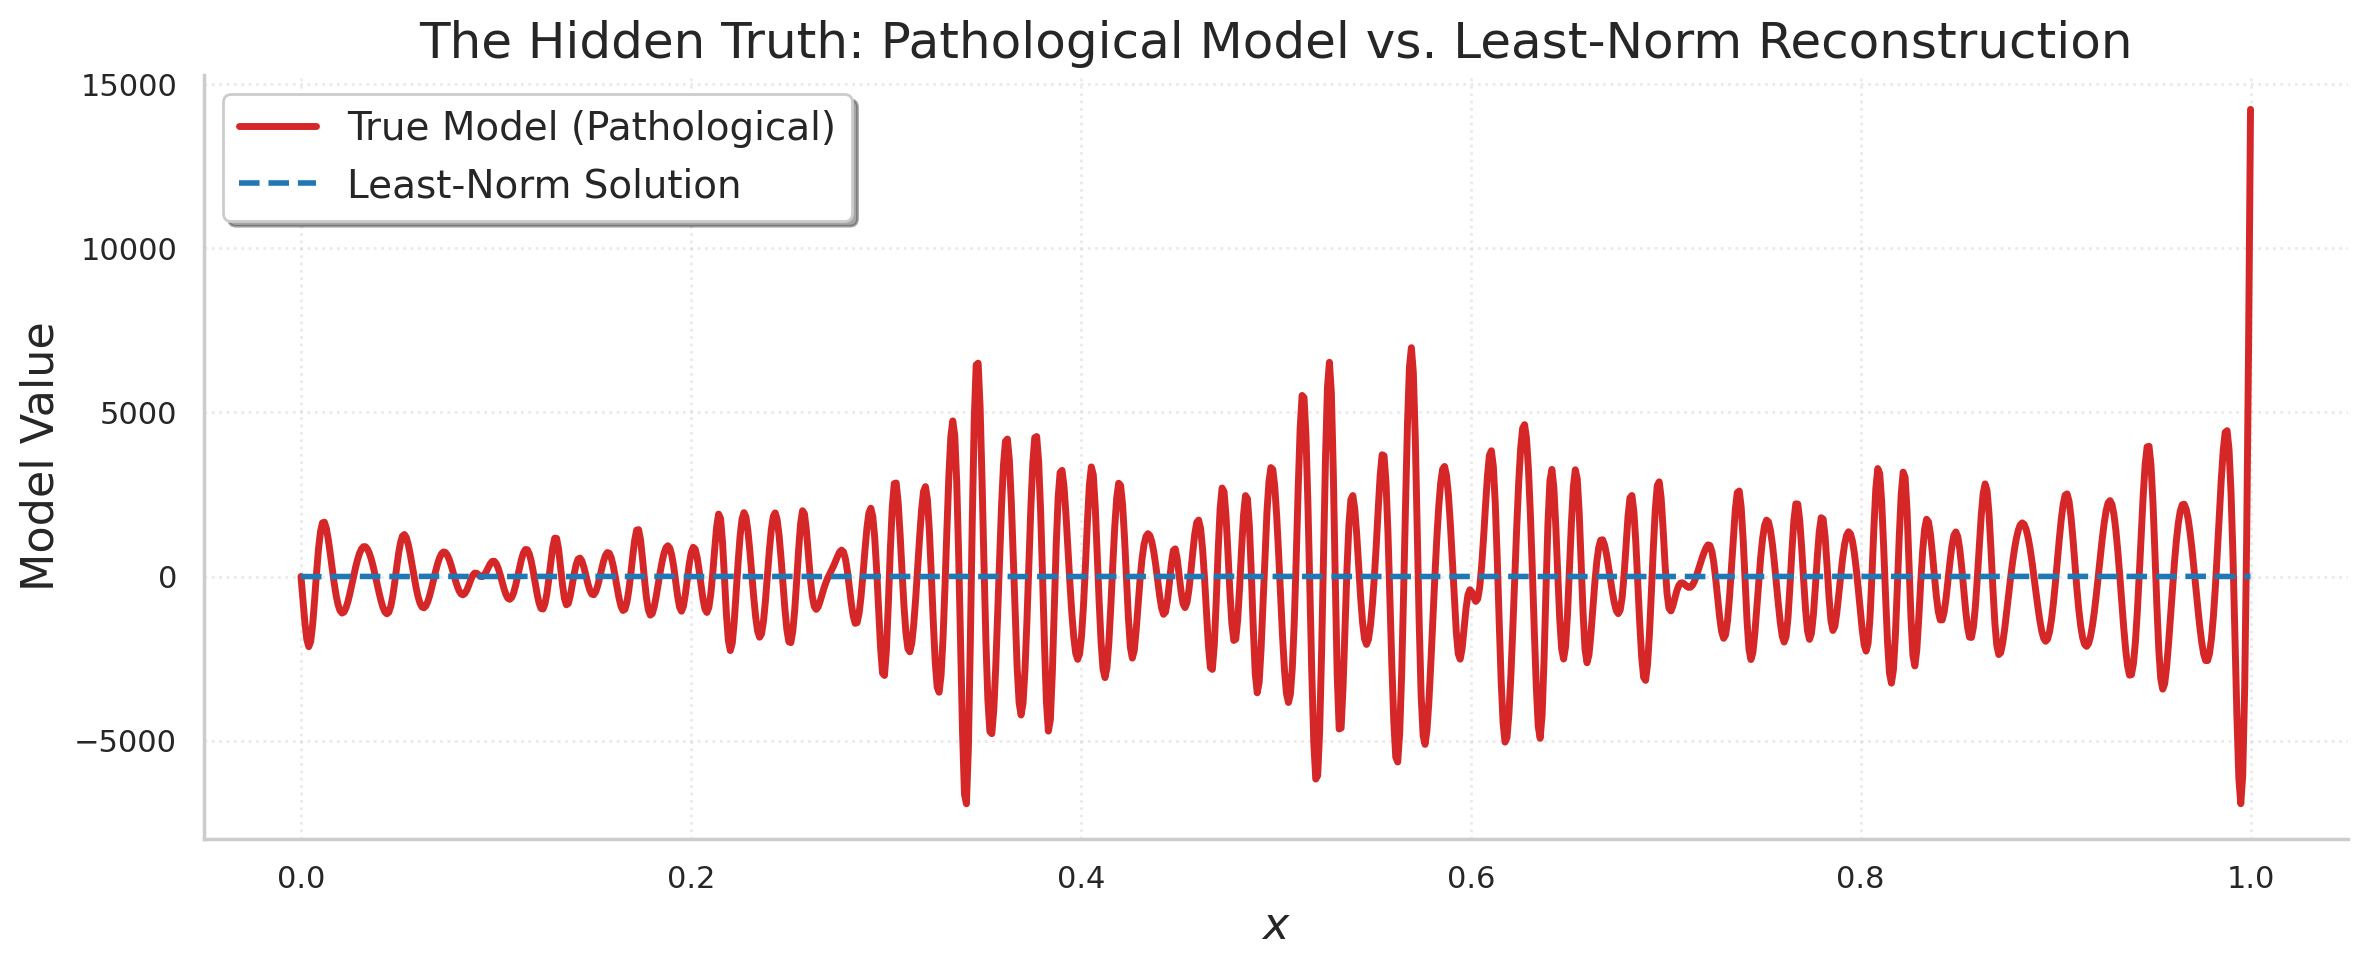


Both models fit the observed data equally well,
but they have completely different properties!

This is the fundamental limitation of SOLA:
It cannot distinguish between models in the null space of G.


In [41]:
# Final visualization: The true model vs the least-norm solution
fig_title = "True Model vs Least Norm Solution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

plt.plot(x, m_true.evaluate(x), label='True Model (Pathological)',
         color='tab:red', linewidth=2.5, linestyle='-')
plt.plot(x, m_least_norm.evaluate(x), label='Least-Norm Solution',
         color='tab:blue', linewidth=2, linestyle='--')

plt.title('The Hidden Truth: Pathological Model vs. Least-Norm Reconstruction', fontsize=18)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel('Model Value', fontsize=16)
plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

print("\nBoth models fit the observed data equally well,")
print("but they have completely different properties!")
print("\nThis is the fundamental limitation of SOLA:")
print("It cannot distinguish between models in the null space of G.")

In [42]:
# Verify both models fit the data equally well
data_fit_true = np.linalg.norm(G(m_true) - d_bar)
data_fit_least_norm = np.linalg.norm(G(m_least_norm) - d_tilde)

print("Data fit verification:")
print(f"  True model data fit error: {data_fit_true:.2e}")
print(f"  Least-norm model data fit error: {data_fit_least_norm:.4f}")
print(f"\nBoth models explain the data, but their properties differ by:")
print(f"  Mean difference: {np.mean(np.abs(p_true - T(m_least_norm))):.4f}")
print(f"  This is {np.mean(np.abs(p_true - T(m_least_norm)))/np.mean(p_std):.1f}x the uncertainty!")

Data fit verification:
  True model data fit error: 4.48e-07
  Least-norm model data fit error: 0.5452

Both models explain the data, but their properties differ by:
  Mean difference: 1.1563
  This is 7.4x the uncertainty!


# Conclusion

This demonstration shows a fundamental limitation of SOLA (and similar methods):

**SOLA assumes the true model has small norm.** When this assumption is violated:
- The property estimates can be arbitrarily wrong
- The uncertainty quantification is meaningless (errors far exceed stated uncertainty)
- There is no way to detect this failure from the data alone

The lesson: SOLA's uncertainty quantification is only valid under the implicit 
assumption that the true model is "simple" (has small norm). Without additional 
prior information about the model, SOLA cannot distinguish between infinitely 
many models that fit the data equally well but have vastly different properties.